# Dataset de consumo energético

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carga del dataset

In [2]:
df = pd.read_csv('extracted_data/csv/hour_merged.csv',
                 parse_dates={'data': ['date', 'time']},
                 infer_datetime_format=True,
                 dayfirst=False,
                 index_col='data'
                )


df.head()

,price,demand,emissions
data,,,
2017-01-01 00:00:00,58.82,24682,14467.2840
2017-01-01 01:00:00,58.23,24046,14173.8295
2017-01-01 02:00:00,51.95,22665,13198.0690
2017-01-01 03:00:00,47.27,21200,12510.7595
2017-01-01 04:00:00,45.49,20056,12203.7315


In [3]:
df.describe()

,price,demand,emissions
count,43800.000000,43800.000000,43800.000000
mean,68.212629,28189.487146,11296.974971
std,63.725022,4595.460802,3952.947375
min,0.010000,16165.000000,3890.149500
25%,40.500000,24380.750000,8181.419000
50%,51.200000,28218.000000,10769.564250
75%,64.100000,31687.000000,13794.362000
max,536.810000,41552.000000,30476.416000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2017-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      43800 non-null  float64
 1   demand     43800 non-null  int64  
 2   emissions  43800 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.3 MB


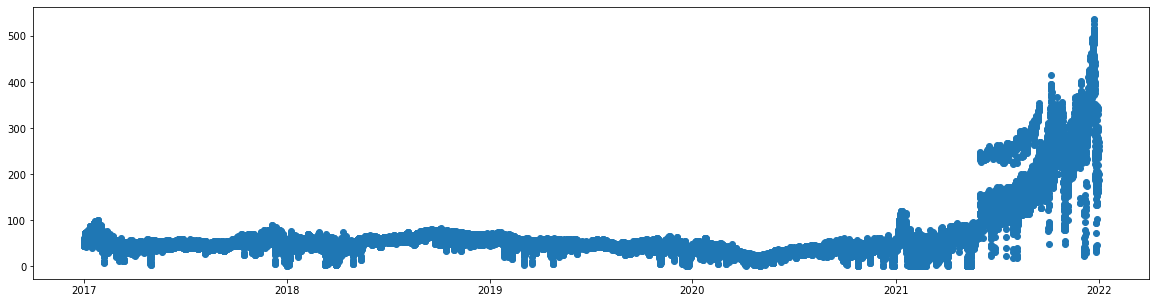

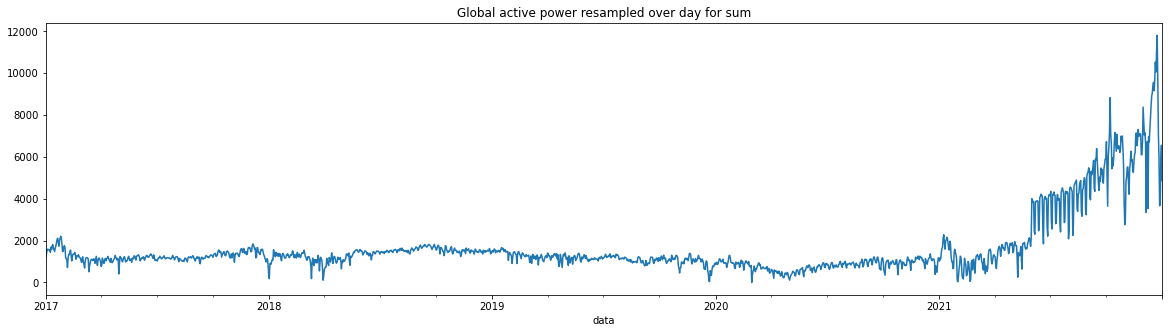

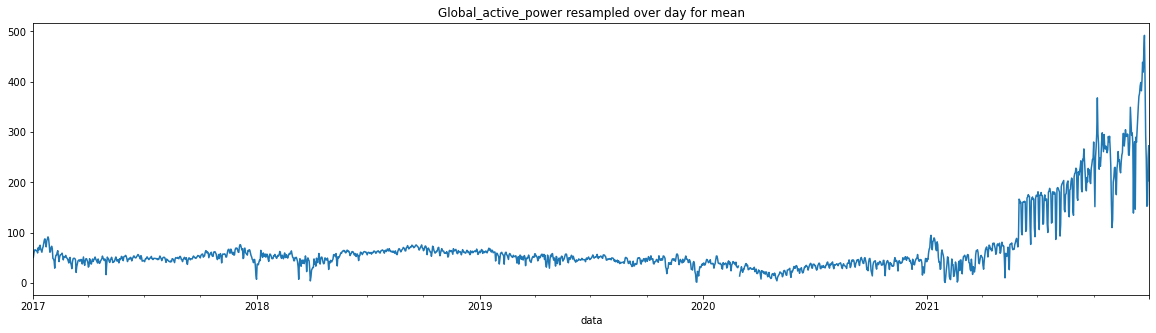

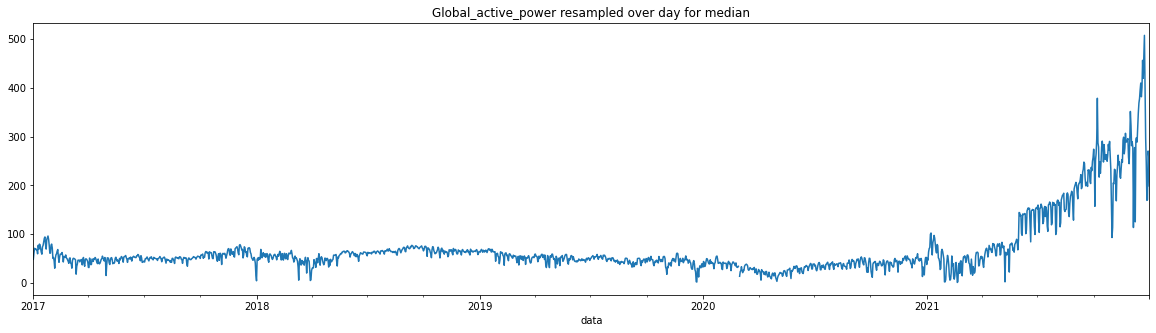

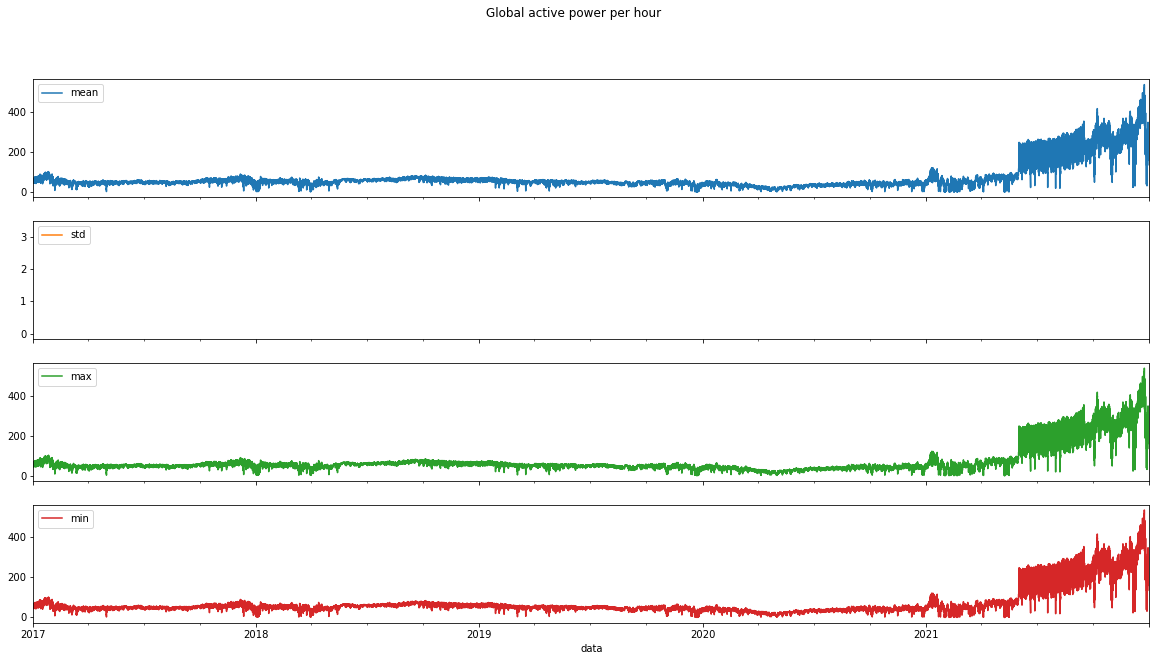

In [5]:
# Scatter plot de Global active power
plt.figure(figsize=(20, 5))
plt.scatter(df.index, df['price'])
plt.show()

# Global active power resampled over day for sum
plt.figure(figsize=(20, 5))
df.price.resample('D').sum().plot(title='Global active power resampled over day for sum')
plt.show()

# # Global active power resampled over day for mean
plt.figure(figsize=(20, 5))
df.price.resample('D').mean().plot(title='Global_active_power resampled over day for mean')
plt.show()

# # Global active power resampled over day for median
plt.figure(figsize=(20, 5))
df.price.resample('D').median().plot(title='Global_active_power resampled over day for median')
plt.show()

# # Global active power per hour
h = df.price.resample('h').agg(['mean', 'std', 'max', 'min'])
h.plot(subplots=True, figsize=(20, 10), title='Global active power per hour')
plt.show()

In [6]:
len(df)

43800

# División en training y test

In [7]:
n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# Normalización (TODO: Normalizar a un valor más alto)
It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. 

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [9]:
train_df.head()

,price,demand,emissions
data,,,
2017-01-01 00:00:00,0.656677,-0.784270,0.616424
2017-01-01 01:00:00,0.616885,-0.919430,0.543476
2017-01-01 02:00:00,0.193338,-1.212916,0.300920
2017-01-01 03:00:00,-0.122299,-1.524253,0.130067
2017-01-01 04:00:00,-0.242349,-1.767372,0.053745


Distribución de las features

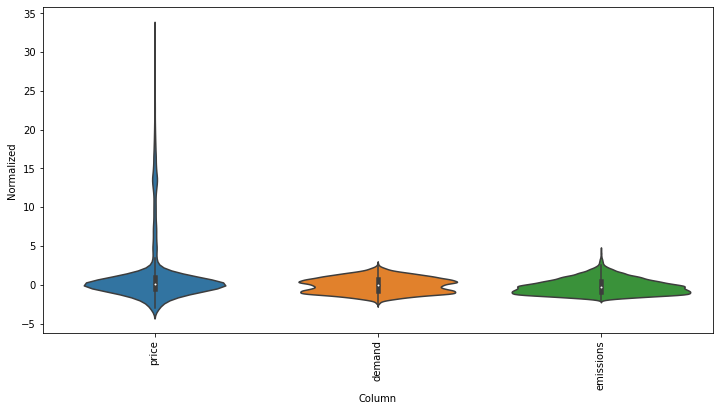

In [10]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Creación de ventanas

In [11]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [12]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [13]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['price'])
print(w1)

w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['price'])
print(w2)

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['price']
Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['price']


In [14]:
example_window = tf.stack([np.array(test_df[:w2.total_window_size]),
                           np.array(test_df[100:100+w2.total_window_size]),
                           np.array(test_df[200:200+w2.total_window_size])
                          ])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 3)
Inputs shape: (3, 6, 3)
Labels shape: (3, 1, 1)


In [15]:
w2.example = example_inputs, example_labels

In [16]:
def plot(self, model=None, plot_col='price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

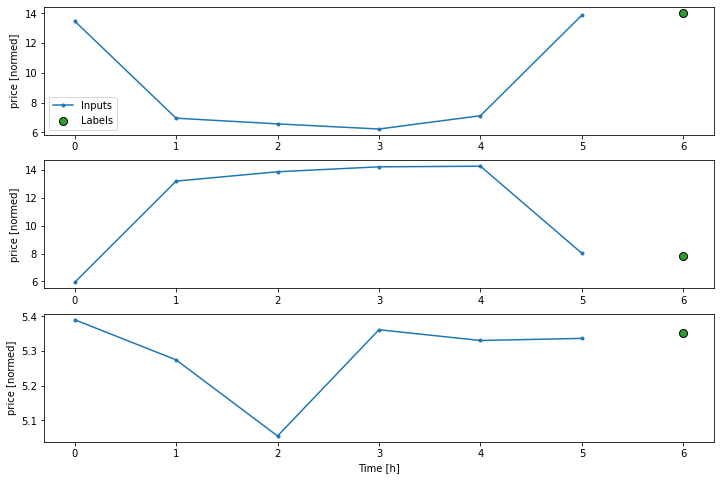

In [17]:
w2.plot()

In [18]:
# De momento, usaremos únicamente la target variable (Household dataset)
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [19]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [20]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [21]:
# Iteramos sobre un conjunto de dataset para producir lotes concretos:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 3)
Labels shape (batch, time, features): (32, 1, 1)


# Multi-step models
Comenzamos intentando predecir una ventana de 24 horas

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

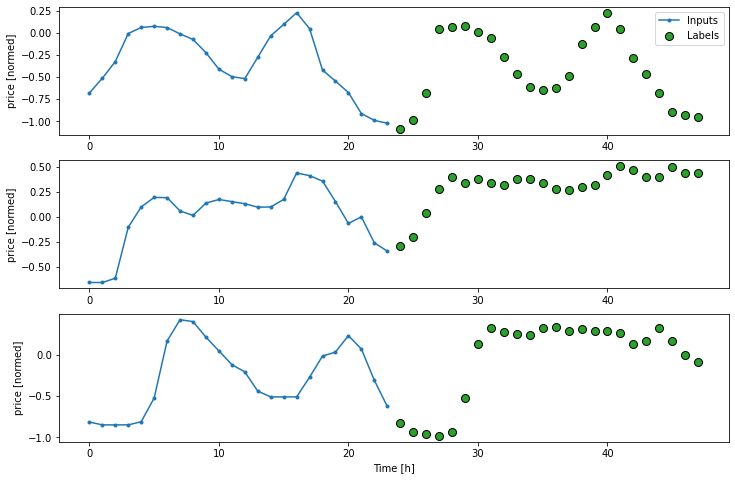

In [22]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)

multi_window.plot()
multi_window

# Baselines
## Baseline 1: Repetir último input

273/273 [==============================] - 1s 2ms/step - loss: 1.4674 - mean_absolute_error: 0.7220 - root_mean_squared_error: 1.2114


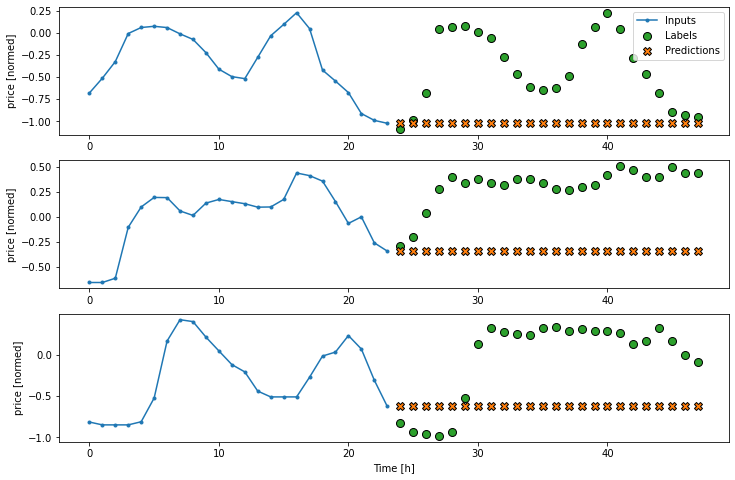

In [25]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(), # TODO: Change
                      metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.RootMeanSquaredError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

## Baseline 2: Repetir la ventana anterior

273/273 [==============================] - 1s 1ms/step - loss: 0.7178 - mean_absolute_error: 0.4577


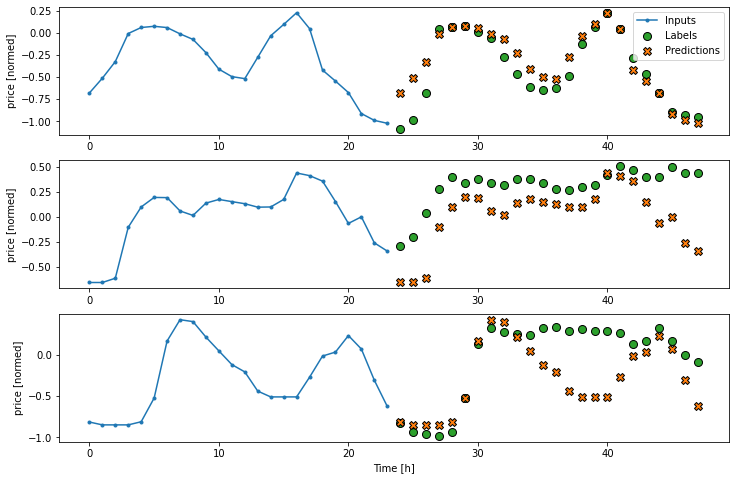

In [26]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.RootMeanSquaredError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

# Single-shot models

## Modelo lineal

In [35]:
num_features=df.shape[1] # TODO: Revisar esta línea

In [36]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(),
                 metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.RootMeanSquaredError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data = window.val, callbacks=[early_stopping])
    
    return history

Epoch 1/20
957/957 [==============================] - 1s 1ms/step - loss: 0.6189 - mean_absolute_error: 0.6282 - root_mean_squared_error: 0.7867 - val_loss: 1.5692 - val_mean_absolute_error: 0.7897 - val_root_mean_squared_error: 1.2527
Epoch 2/20
957/957 [==============================] - 1s 763us/step - loss: 0.4883 - mean_absolute_error: 0.5406 - root_mean_squared_error: 0.6988 - val_loss: 1.2551 - val_mean_absolute_error: 0.6904 - val_root_mean_squared_error: 1.1203
Epoch 3/20
957/957 [==============================] - 1s 791us/step - loss: 0.4766 - mean_absolute_error: 0.5270 - root_mean_squared_error: 0.6904 - val_loss: 1.2129 - val_mean_absolute_error: 0.6656 - val_root_mean_squared_error: 1.1013
Epoch 4/20
957/957 [==============================] - 1s 763us/step - loss: 0.4759 - mean_absolute_error: 0.5255 - root_mean_squared_error: 0.6898 - val_loss: 1.2088 - val_mean_absolute_error: 0.6621 - val_root_mean_squared_error: 1.0995
Epoch 5/20
957/957 [==============================

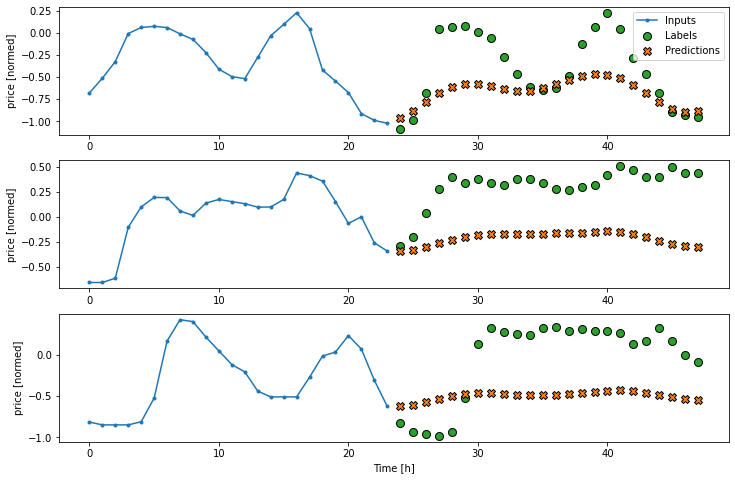

In [37]:
multi_linear_model = tf.keras.Sequential([
    # Seleccionar el último timestep
    # Forma: [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                         kernel_initializer=tf.initializers.zeros()),
    # Shape =>[batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

# IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

## CNN

Epoch 1/20
957/957 [==============================] - 2s 1ms/step - loss: 0.4113 - mean_absolute_error: 0.4831 - root_mean_squared_error: 0.6413 - val_loss: 1.1172 - val_mean_absolute_error: 0.6191 - val_root_mean_squared_error: 1.0570
Epoch 2/20
957/957 [==============================] - 1s 920us/step - loss: 0.3446 - mean_absolute_error: 0.4367 - root_mean_squared_error: 0.5871 - val_loss: 1.1388 - val_mean_absolute_error: 0.6179 - val_root_mean_squared_error: 1.0671
Epoch 3/20
273/273 [==============================] - 0s 595us/step - loss: 1.1949 - mean_absolute_error: 0.6179 - root_mean_squared_error: 1.0931


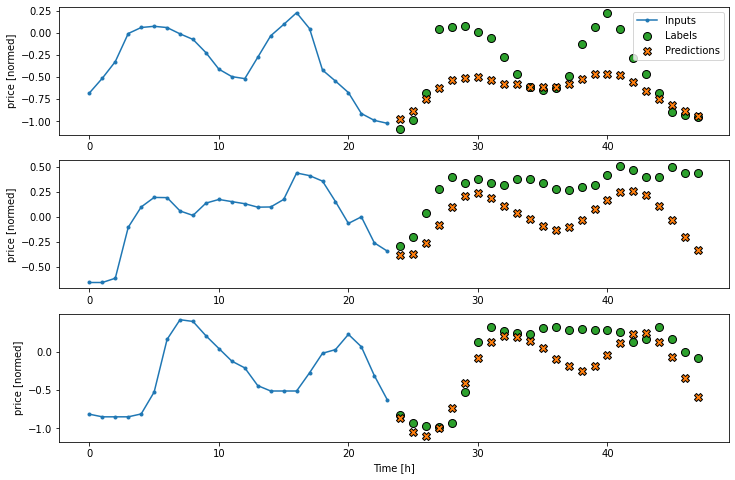

In [38]:
CONV_WIDTH = 3

multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

## RNN

Epoch 1/20
957/957 [==============================] - 6s 5ms/step - loss: 0.3642 - mean_absolute_error: 0.4561 - root_mean_squared_error: 0.6035 - val_loss: 1.5216 - val_mean_absolute_error: 0.5846 - val_root_mean_squared_error: 1.2335
Epoch 2/20
957/957 [==============================] - 5s 5ms/step - loss: 0.1827 - mean_absolute_error: 0.3150 - root_mean_squared_error: 0.4274 - val_loss: 1.4584 - val_mean_absolute_error: 0.5593 - val_root_mean_squared_error: 1.2077
Epoch 3/20
957/957 [==============================] - 5s 5ms/step - loss: 0.1594 - mean_absolute_error: 0.2927 - root_mean_squared_error: 0.3993 - val_loss: 1.4067 - val_mean_absolute_error: 0.5464 - val_root_mean_squared_error: 1.1861
Epoch 4/20
957/957 [==============================] - 5s 5ms/step - loss: 0.1496 - mean_absolute_error: 0.2826 - root_mean_squared_error: 0.3868 - val_loss: 1.3651 - val_mean_absolute_error: 0.5310 - val_root_mean_squared_error: 1.1684
Epoch 5/20
957/957 [==============================] - 5s

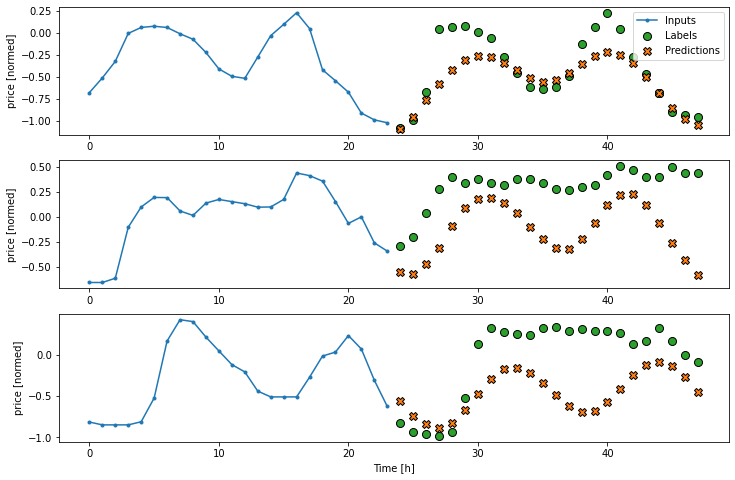

In [39]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Es peligroso añadir demasiadas unidades lstm, ya que pueden causar overfitting
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    # Shape [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

# Modelo auto-regresivo

In [40]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [41]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [42]:
def warmup(self, inputs):
    # Forma del input => (batch, time, features)
    # Forma de x => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)
    
    # Forma de la predicción => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [43]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 3])

In [44]:
def call(self, inputs, training=None):
    # Usar un TensorArray para capturar unrolled outputs automáticamente
    predictions = []
    # Inicializar el estado de LSTM
    prediction, state = self.warmup(inputs)
    
    # Insertar la primera predicción
    predictions.append(prediction)
    
    # Ejecutar el resto de pasos de la predicción
    for n in range(1, self.out_steps):
        # Usar la última predicción como input
        x = prediction
        # Ejecutar un paso de lstm
        x, state = self.lstm_cell(x, states=state, training=training)
        # Convertir la salida de lstm en una predicción
        prediction = self.dense(x)
        # Añadir la predicción al output
        predictions.append(prediction)
    
    # Forma de predictions => (time, batch, features)
    predictions = tf.stack(predictions)
    # Forma de predictions => (batch, time, features)
    predictions = tf.transpose(predictions, [1,0,2])
    
    return predictions

FeedBack.call = call

In [45]:
print('Forma del output: ', feedback_model(multi_window.example[0]).shape)

Forma del output:  (32, 24, 3)


Epoch 1/20
957/957 [==============================] - 10s 8ms/step - loss: 0.3453 - mean_absolute_error: 0.4401 - root_mean_squared_error: 0.5876 - val_loss: 1.5156 - val_mean_absolute_error: 0.5859 - val_root_mean_squared_error: 1.2311
Epoch 2/20
957/957 [==============================] - 7s 7ms/step - loss: 0.2005 - mean_absolute_error: 0.3293 - root_mean_squared_error: 0.4478 - val_loss: 1.4550 - val_mean_absolute_error: 0.5874 - val_root_mean_squared_error: 1.2062
Epoch 3/20
957/957 [==============================] - 7s 7ms/step - loss: 0.1783 - mean_absolute_error: 0.3090 - root_mean_squared_error: 0.4223 - val_loss: 1.4365 - val_mean_absolute_error: 0.5649 - val_root_mean_squared_error: 1.1985
Epoch 4/20
957/957 [==============================] - 7s 7ms/step - loss: 0.1647 - mean_absolute_error: 0.2960 - root_mean_squared_error: 0.4058 - val_loss: 1.4532 - val_mean_absolute_error: 0.5593 - val_root_mean_squared_error: 1.2055
Epoch 5/20
957/957 [==============================] - 7

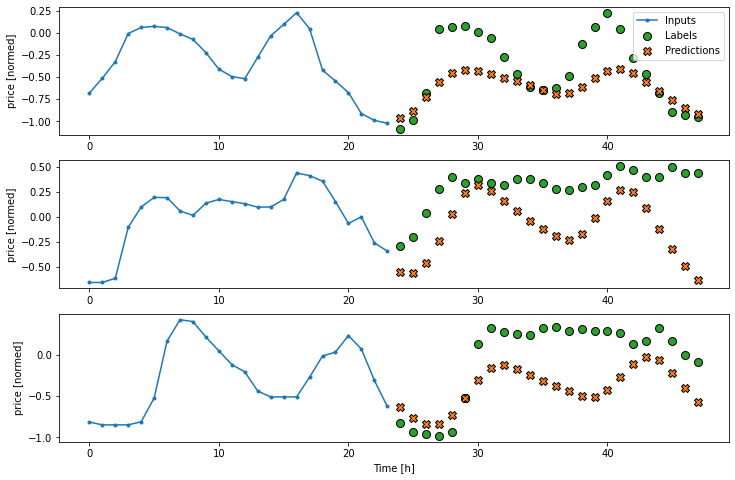

In [46]:
history = compile_and_fit(feedback_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

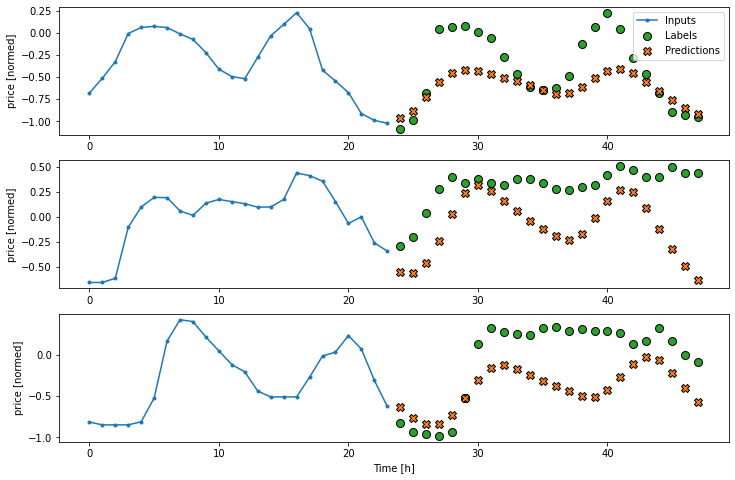

In [47]:
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)